In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import sqrt, log

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ← convert RGB → grayscale
    transforms.ToTensor(),                         # shape: (1, 32, 32)
    transforms.Normalize((0.0,), (1.0,))            # single channel
])
dataset = torchvision.datasets.CIFAR10(root="./sample_data", train=True, download=False, transform=transform)
dataset = torchvision.datasets.MNIST(root="./sample_data", train=True, download=False, transform=transform)

In [142]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [229]:
data, labels = next(iter(dataloader))
gram_matrix =  torch.einsum('ki,li->kl', data.view(data.size(0), -1), data.view(data.size(0), -1))
diag = torch.diagonal(gram_matrix)
C = gram_matrix / torch.sqrt(torch.outer(diag, diag))

In [230]:
torch.unique(labels, return_counts=True)  # check class balance

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 99, 130, 111,  74, 109,  82, 102,  91, 111, 115]))

In [236]:
# dual approach
betas = torch.logspace(0, 2, 1000)
K = C.size(0)
w = torch.distributions.dirichlet.Dirichlet(torch.ones(K)).sample((betas.size(0),))
eta = 0.9
# w = softmax(beta*C @ w)
for step in range(30000):
    current = torch.softmax(betas[:,None] * w @ C, dim=1)
    w = eta*w + (1-eta)*current
    #w += dt*(w @ C - (torch.log(w)+1)/betas[:, None])
    #w /= w.sum(dim=1, keepdim=True)

In [237]:
recovered_patterns = (w @ data.view(data.size(0), -1)).view(-1, data.size(-2), data.size(-1))

In [239]:
class_weight = torch.zeros((betas.size(0), 10), device=w.device, dtype=w.dtype)

class_weight = class_weight.scatter_add_(
    dim=1,
    index=labels.unsqueeze(0).expand(betas.size(0), K),
    src=w
)

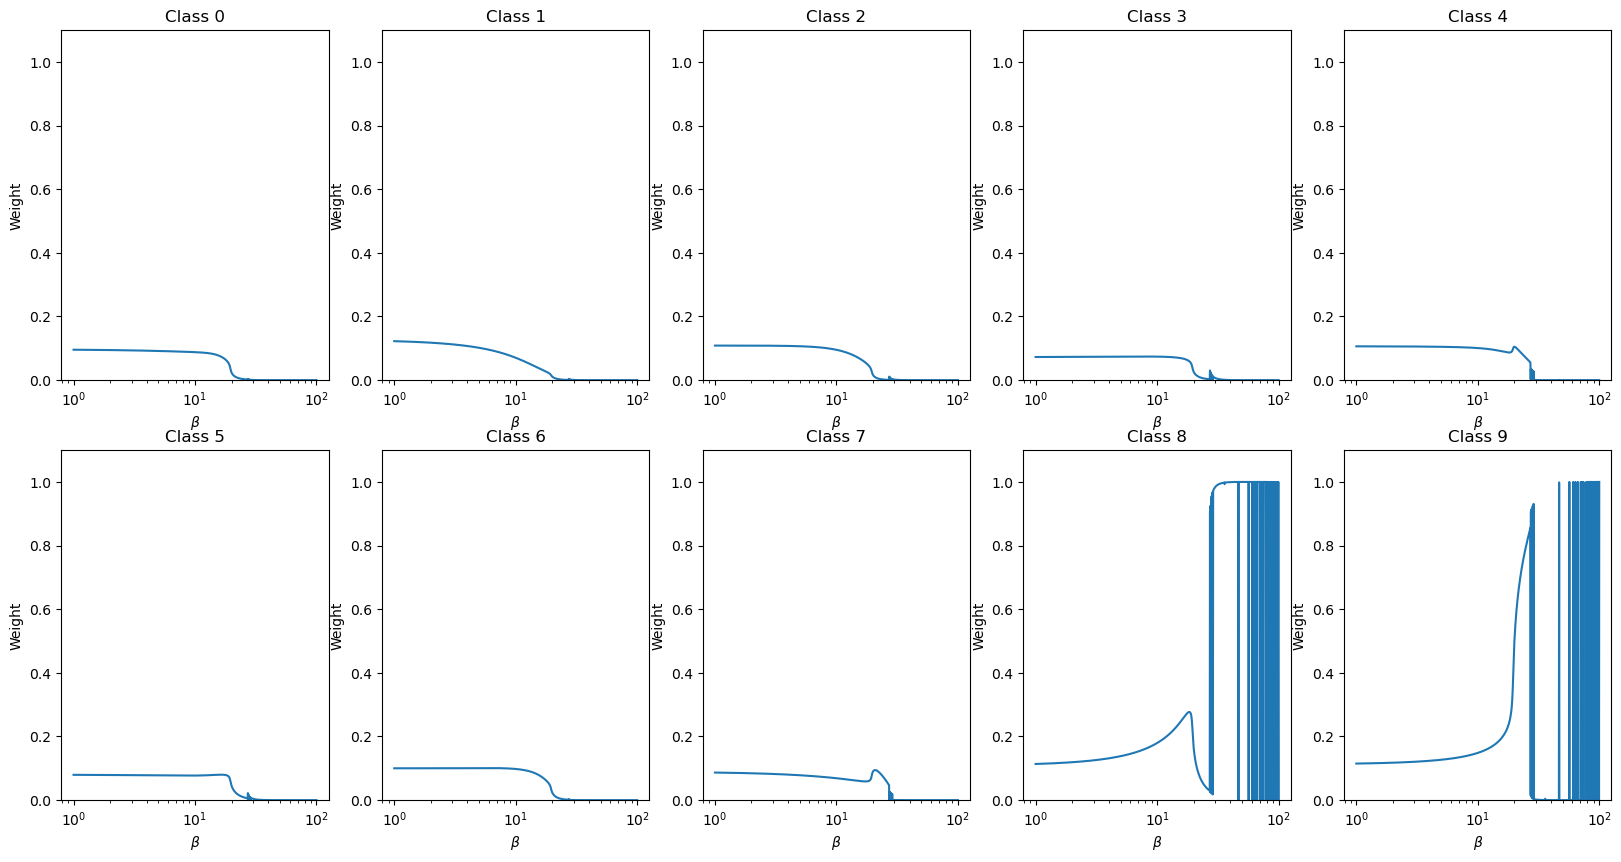

In [240]:
fig, axs = plt.subplots(2,5, figsize=(20, 10))
for label in range(10):
    ax = axs[label // 5, label % 5]
    ax.plot(betas, class_weight[:, label])
    ax.set_xscale('log')
    ax.set_title(f'Class {label}')
    ax.set_xlabel('$\\beta$')
    ax.set_ylabel('Weight')
    ax.set_ylim(0, class_weight.max().item() * 1.1)
plt.show()

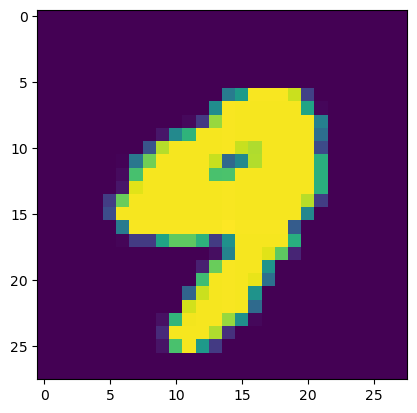

In [242]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []
for i in range(betas.size(0)):
    im = plt.imshow(recovered_patterns[i].detach().cpu(), animated=True, cmap='viridis')
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                            repeat_delay=1000)
ani.save('enet.mp4', writer='imagemagick')

In [161]:
part_ratio = ((w**2).sum(dim=1)**2)/(w**4).sum(dim=1)

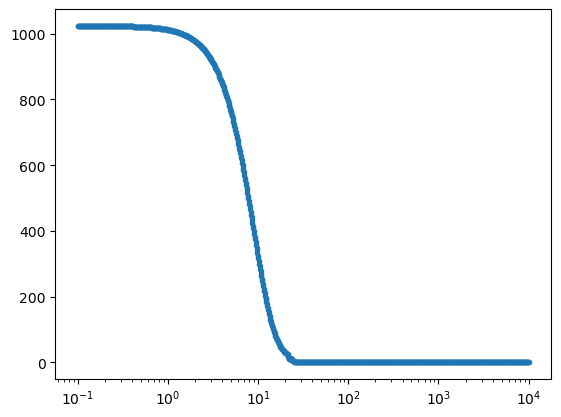

In [162]:
plt.plot(betas, part_ratio, marker='.')
plt.xscale('log')

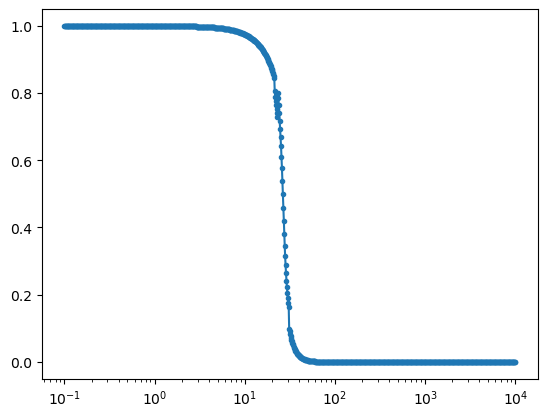

In [163]:
plt.plot(betas, (-w*torch.log(w)).sum(dim=1)/torch.log(torch.tensor(K)), marker='.')
plt.xscale('log')

In [ ]:
K = 1024
B = K // 32
rho1 = 1.0/(B-1)
rho0 = 0.99/(K-1)
m_a = torch.arange(1,1+B).float()
m_b = torch.arange(1, 1 + K//B).float()


In [ ]:
%matplotlib inline
for beta in torch.logspace(0, 5, 25):
    F = (1-rho0)/(2*m_a[:,None]*m_b[None,:]) + torch.log(m_a[:,None]*m_b[None,:])/(beta) + (rho0-rho1)/(2*m_b)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(*torch.meshgrid(m_a, m_b), F, facecolors=plt.cm.viridis((F - F.min()) / (F.max() - F.min())), rstride=1, cstride=1, antialiased=False)
    ax.set_xlabel("m_a")
    ax.set_ylabel("m_b")
    ax.set_title( f"Beta: {beta:.2e} " + str(1+torch.tensor(torch.unravel_index(torch.argmax(F), F.shape))))
    plt.show()

In [ ]:
K = 1024
B = K // 32
N = 16
rho1 = 0.1
rho0 = -0.5/(K-1)
C = rho0*torch.ones((K,K))
for g in range(0,K, B):
    C[g:g+B, g:g+B] = rho1  
#rho = 0.1/(K-1)
#C = rho*torch.ones((K,K))
_ = torch.diagonal(C).fill_(1.0)
L = torch.linalg.cholesky(C) 
P = (torch.randn((N,K)) @ L.T).T

In [ ]:
#m = torch.arange(1, 1+K).float()
#F = (1-rho)/(2*m[None,:]) + torch.log(m[None,:])/(betas[:,None])
#plt.contourf(torch.log(F), levels=20)
#plt.colorbar()

In [ ]:
# dual approach
betas = torch.logspace(-5, 5, 200)
w = torch.distributions.dirichlet.Dirichlet(torch.ones(K)).sample((betas.size(0),))
eta = 0.9
# w = softmax(beta*C @ w)
for step in range(5000):
    current = torch.softmax(betas[:,None] * w @ C, dim=1)
    w = eta*w + (1-eta)*current
    #w += dt*(w @ C - (torch.log(w)+1)/betas[:, None])
    #w /= w.sum(dim=1, keepdim=True)

In [ ]:
plt.scatter(betas, - (torch.log(w)*w).sum(dim=1)/log(K))
#plt.gca().twinx().plot(betas,torch.clip(betas*(1-rho)/2, 1, K).int()/K)
plt.xscale('log')
plt.xlabel('$\\beta$')
plt.ylabel("Entropy")
plt.show()

In [ ]:
betas = torch.linspace(0.5, 1.0, 200)
x = torch.randn((betas.size(0), N))
dt =0.01
for step in range(100000):
    y = (betas[:, None, None] * P[None, :, :] * x[:, None, :]).sum(dim=2)
    w = torch.softmax(y, dim=-1)
    x += dt*((P[None, :, :]*w[:, :, None]).sum(dim=1) - x)

In [ ]:
plt.scatter(betas, -torch.sum(w*torch.log(w), dim=1) / torch.log(torch.tensor(K)))

In [ ]:
plt.scatter(betas, torch.sum(w**4, dim=1)/torch.sum(w**2, dim=1)**2, marker='o')
plt.show()